In [34]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit 

import hhmodel as hh

from importlib import reload
reload(hh)

<module 'hhmodel' from 'c:\\Users\\jungyoung\\Desktop\\Project\\hhneuron_example\\hhmodel.py'>

# Dynamics of HH model

In [6]:
obj = hh.hhmodel(dt=0.01, gna0=120, gk0=36, gl=0.3, ena=55, ek=-77, el=-65)

f_ic = lambda t: 0 if t < 20 else 9
obj.run(f_ic, tmax=100, disable_tqdm=False)

100%|██████████| 10000/10000 [00:00<00:00, 304457.95it/s]


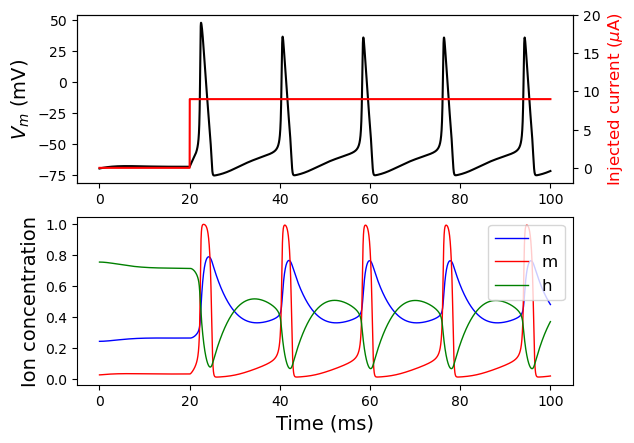

In [10]:
plt.figure()
plt.subplot(211)
plt.plot(obj.ts, obj.vs, c='k')
plt.ylabel(r"$V_m$ (mV)", fontsize=14)

plt.twinx()
plt.plot(obj.ts, [f_ic(t) for t in obj.ts], 'r')
plt.ylim([-2, 20])
plt.ylabel(r"Injected current ($\mu$A)", fontsize=12, color="r")

plt.subplot(212)
plt.plot(obj.ts, obj.ns, c='b', lw=1, label="n")
plt.plot(obj.ts, obj.ms, c='r', lw=1, label="m")
plt.plot(obj.ts, obj.hs, c='g', lw=1, label="h")
plt.xlabel("Time (ms)", fontsize=14)
plt.ylabel("Ion concentration", fontsize=14)
plt.legend(fontsize=12, loc="upper right")

plt.show()

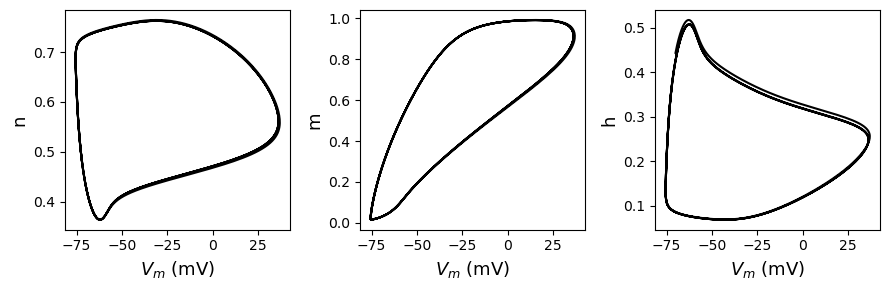

In [13]:
idt = (obj.ts >= 30)

def show_label(ylb):
    plt.xlabel(r"$V_m$ (mV)", fontsize=13)
    plt.ylabel(ylb, fontsize=13)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.plot(obj.vs[idt], obj.ns[idt], c='k')
show_label("n")

plt.subplot(132)
plt.plot(obj.vs[idt], obj.ms[idt], c='k')
show_label("m")

plt.subplot(133)
plt.plot(obj.vs[idt], obj.hs[idt], c='k')
show_label("h")

plt.tight_layout()
plt.show()

# Response curve

In [132]:
hhparams = dict(
    gna0=120, gk0=36, gl=0.3, ena=55, ek=-77, el=-65   
)

np.random.seed(300)

dt, tmax = 0.01, 2000

nmax = int(tmax/dt)
ic_sets = np.linspace(5, 12, 21)
nitr = 10

ic_input_set = []
for ic in ic_sets:
    for n in range(nitr): # run 10 times and average the firing rate
        ic_input_set.append(np.ones(nmax) * ic)
        ic_input_set[-1][:int(10/dt)] = 0

fr_set = hh.compute_fr_multi_inputs(ic_input_set, tmax, dt=dt,
                                    **hhparams)

100%|██████████| 210/210 [00:54<00:00,  3.85it/s]


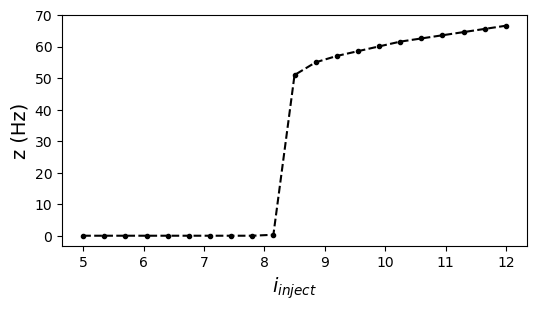

In [134]:
fr_set_avg = np.average(fr_set.reshape(-1, 10), axis=1)

plt.figure(figsize=(6, 3))
plt.plot(ic_sets, fr_set_avg, 'k.--')
plt.xlabel(r"$i_{inject}$", fontsize=14)
plt.ylabel("z (Hz)", fontsize=14)
# plt.xlim([7, 7.5])
plt.show()

## Response curve near $i_{inject, T}$

In [135]:
ic_sets_d = np.linspace(8.2, 8.6, 31)
ic_input_set_d = []

nitr = 20

for ic in ic_sets_d:
    for _ in range(nitr):
        ic_arr = np.ones(nmax) * ic
        ic_arr[:int(10/dt)] = 0
        ic_input_set_d.append(ic_arr)

fr_set_d = hh.compute_fr_multi_inputs(ic_input_set_d, tmax, dt=dt,
                                      **hhparams)

100%|██████████| 620/620 [02:29<00:00,  4.15it/s]


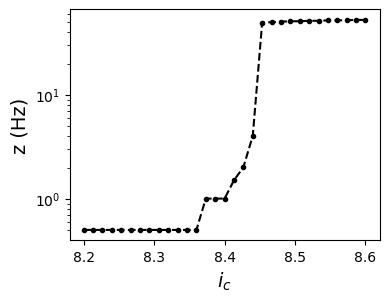

In [149]:
fr_avg = np.average(fr_set_d.reshape(-1, nitr), axis=1)

plt.figure(figsize=(4, 3))
plt.plot(ic_sets_d, fr_avg, 'k.--')
plt.xlabel(r"$i_c$", fontsize=14)
plt.ylabel("z (Hz)", fontsize=14)
plt.yscale("log")
# plt.xlim([7, 7.5])
plt.show()

In [62]:
from functools import partial

ic_array_sets = []

tmax, dt = 2000, 0.01
nmax = int(tmax/dt)

ic_sets = np.linspace(8.2, 8.6, 21)
for i, ic in enumerate(ic_sets):
    for nt in range(10):
        ic_array_sets.append(np.ones(nmax) * ic)

In [63]:
fr_sets = hh.compute_fr_multi_inputs(ic_array_sets, dt=dt, tmax=2000,
                                     gna0=120, gk0=36, gl=0.3, ena=55, ek=-77, el=-65)

100%|██████████| 210/210 [00:55<00:00,  3.80it/s]


In [64]:
frs = fr_sets.reshape(-1, 10)

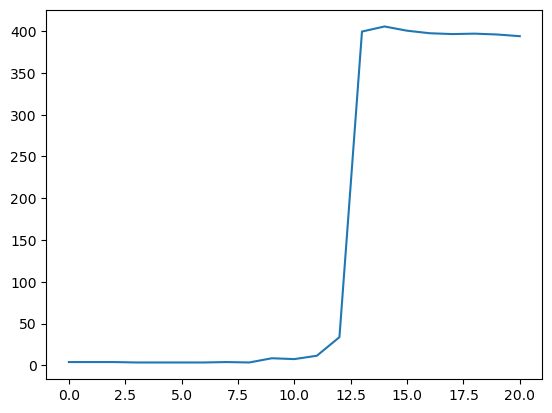

In [65]:
plt.plot(np.average(frs, axis=1))

In [14]:
from functools import partial

In [18]:
def test(x, *args):
    print(x, args)

f = partial(test, 1,2)

In [19]:
f(1,2,3)

1 (2, 1, 2, 3)


# Oscillatory input

In [21]:
hhparams = dict(gna0=120, gk0=36, gl=0.3, ena=55, ek=-77, el=-65)
sobj = hh.hhmodel(**hhparams)

dt, tmax = 0.01, 1000
t  = np.arange(int(tmax/dt)) * dt

srate = 2
ic_osc = np.sin(2*np.pi * srate * t) + 8.5

sobj.run(lambda t: ic_osc[int(t/dt)], tmax=tmax)

100%|██████████| 100000/100000 [00:00<00:00, 384906.94it/s]


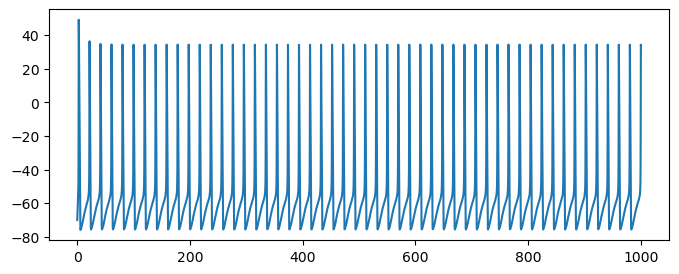

In [22]:
plt.figure(figsize=(8, 3))
plt.plot(sobj.ts, sobj.vs)
plt.show()

In [30]:
srate_set = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 4, 8]

dt, tmax = 0.01, 10000
t  = np.arange(int(tmax/dt)) * dt


ic_osc_set = []
for n in range(len(srate_set)):
    ic_osc_set.append(np.sin(2*np.pi*srate_set[n] * t) + 8.5)


fr_sets = hh.compute_fr_multi_inputs(ic_osc_set, tmax, dt=dt, teq=20, **hhparams)

100%|██████████| 9/9 [00:17<00:00,  1.93s/it]


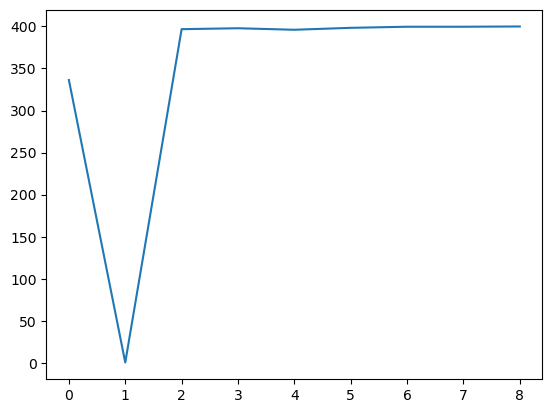

In [31]:
plt.plot(fr_sets)

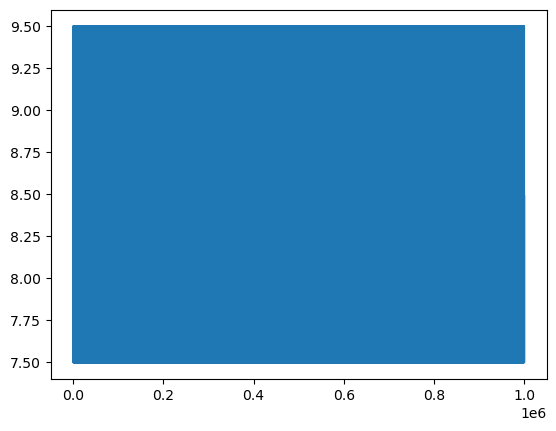

In [32]:
plt.plot(ic_osc_set[1])

In [3]:
from multiprocessing import Pool
from tqdm import tqdm

# _use_jit = True
_ncore = 2


def compute_fr_multi_inputs(ic_sets, **hhparams):
    # sobj = hhmodel(**hhparams)
    res = []
    
    with Pool(processes=_ncore) as p:
        with tqdm(total=10) as pbar:
            for _, r in enumerate(p.imap(test, range(0, 10))):
                res.append(r)
                pbar.update()
    
    return res
    
def test(c):
    return 10*c + c

In [5]:
res = compute_fr_multi_inputs([])

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
from multiprocess import Pool
from tqdm.notebook import tqdm

_ncore = 4

def parrun(func, args, desc=None):
    
    outs = []
    p = Pool(_ncore)
    with tqdm(total=len(args), desc=desc) as pbar:
        if _ncore == 1:
            for res in args:
                outs.append(func(res))
                pbar.update() 
        else:
            for n, res in enumerate(p.imap(func, args)):
                outs.append(res)
                pbar.update()
            
    # id_sort = np.argsort([o[0] for o in outs])
    # res = [outs[i][1:] for i in id_sort]
    p.close()
    p.join()
    
    return outs


def test(c):
    return 10*c + c


In [11]:
out = parrun(test, list(range(10)))

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
out

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

In [1]:
from multiprocess import Pool

In [4]:
for n in range(10):
    print(test(n))

0
11
22
33
44
55
66
77
88
99
